Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8792, 28, 28) (8792,)
Test set (5444, 28, 28) (5444,)


In [3]:
print(np.bincount(test_labels), np.bincount(test_labels).std())
print(np.bincount(valid_labels), np.bincount(valid_labels).std())

[545 548 571 556 545 546 555 535 482 561] 22.8656948287
[898 906 899 888 895 900 885 875 775 871] 36.3312537631


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    reshaped_dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    one_hot_labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return reshaped_dataset, one_hot_labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (8792, 784) (8792, 10)
Test set (5444, 784) (5444, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():
  
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random valued following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction  = tf.nn.softmax(tf.matmul(tf_test_dataset,  weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 17.097319
Training accuracy: 14.4%
Validation accuracy: 15.9%
Test accuracy: 15.6%
Loss at step 100: 2.287210
Training accuracy: 72.7%
Validation accuracy: 69.9%
Test accuracy: 68.8%
Loss at step 200: 1.840459
Training accuracy: 75.3%
Validation accuracy: 72.2%
Test accuracy: 71.2%
Loss at step 300: 1.600656
Training accuracy: 76.7%
Validation accuracy: 73.1%
Test accuracy: 71.9%
Loss at step 400: 1.440506
Training accuracy: 77.5%
Validation accuracy: 73.6%
Test accuracy: 72.4%
Loss at step 500: 1.321077
Training accuracy: 78.1%
Validation accuracy: 73.8%
Test accuracy: 72.9%
Loss at step 600: 1.226504
Training accuracy: 78.4%
Validation accuracy: 74.0%
Test accuracy: 73.0%
Loss at step 700: 1.149154
Training accuracy: 78.8%
Validation accuracy: 74.2%
Test accuracy: 73.3%
Loss at step 800: 1.084596
Training accuracy: 79.3%
Validation accuracy: 74.4%
Test accuracy: 73.5%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
  
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.452770
Minibatch accuracy: 5.5%
Validation accuracy: 11.3%
Test accuracy: 11.0%
Minibatch loss at step 500: 1.387662
Minibatch accuracy: 75.8%
Validation accuracy: 75.3%
Test accuracy: 73.8%
Minibatch loss at step 1000: 1.315554
Minibatch accuracy: 75.0%
Validation accuracy: 76.4%
Test accuracy: 74.8%
Minibatch loss at step 1500: 1.181916
Minibatch accuracy: 79.7%
Validation accuracy: 76.0%
Test accuracy: 74.5%
Minibatch loss at step 2000: 0.833501
Minibatch accuracy: 78.9%
Validation accuracy: 77.0%
Test accuracy: 76.0%
Minibatch loss at step 2500: 0.836437
Minibatch accuracy: 85.2%
Validation accuracy: 77.7%
Test accuracy: 76.2%
Minibatch loss at step 3000: 0.974220
Minibatch accuracy: 79.7%
Validation accuracy: 78.3%
Test accuracy: 76.7%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [12]:
batch_size = 128

hidden_layer_activation_fn = tf.nn.relu # achieved 84% test accuracy
# hidden_layer_activation_fn = tf.nn.elu # achieved 89.2% test accuracy

graph = tf.Graph()
with graph.as_default():
  
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # Hidden Layer.
    hidden_layer_size = 1024
    weights_h = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    biases_h = tf.Variable(tf.zeros([hidden_layer_size]))
    hidden_out = hidden_layer_activation_fn(tf.matmul(tf_train_dataset, weights_h) + biases_h)
    
    
    # Output Layer.
    weights = tf.Variable(
        tf.truncated_normal([hidden_layer_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    
    # Training computation.
    logits = tf.matmul(hidden_out, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(hidden_layer_activation_fn(tf.matmul(tf_valid_dataset, weights_h) + biases_h), weights) + biases)
    test_prediction = tf.nn.softmax(
        tf.matmul(hidden_layer_activation_fn(tf.matmul(tf_test_dataset, weights_h) + biases_h), weights) + biases)

Initialized


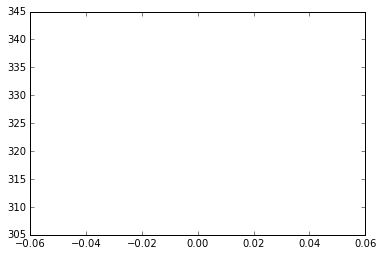

Minibatch loss at step 0: 325.421356
Minibatch accuracy: 7.0%
Validation accuracy: 29.1%
Test accuracy: 29.1%


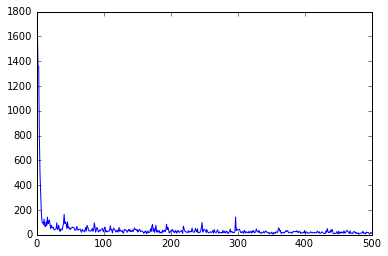

Minibatch loss at step 500: 12.282251
Minibatch accuracy: 82.8%
Validation accuracy: 79.8%
Test accuracy: 78.9%


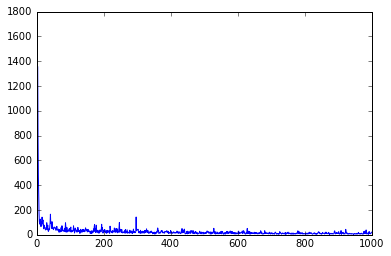

Minibatch loss at step 1000: 20.857117
Minibatch accuracy: 79.7%
Validation accuracy: 77.4%
Test accuracy: 77.3%


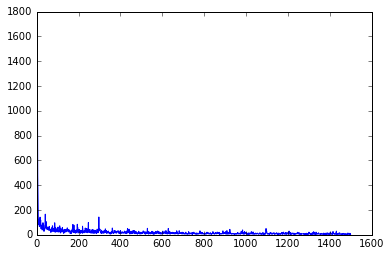

Minibatch loss at step 1500: 2.897059
Minibatch accuracy: 85.9%
Validation accuracy: 80.2%
Test accuracy: 79.7%


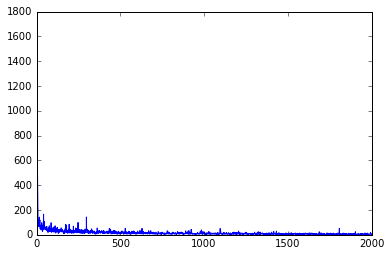

Minibatch loss at step 2000: 3.513537
Minibatch accuracy: 85.2%
Validation accuracy: 80.2%
Test accuracy: 79.5%


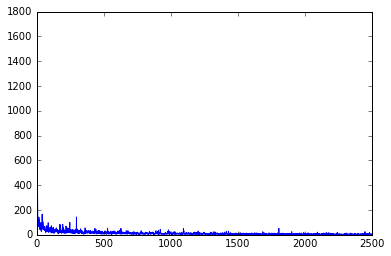

Minibatch loss at step 2500: 3.765988
Minibatch accuracy: 86.7%
Validation accuracy: 80.2%
Test accuracy: 79.4%


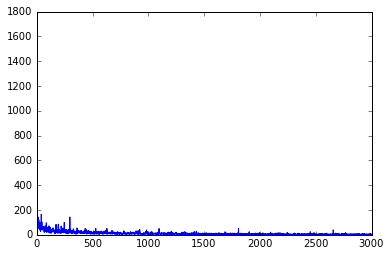

Minibatch loss at step 3000: 4.272042
Minibatch accuracy: 78.1%
Validation accuracy: 79.8%
Test accuracy: 79.0%


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

lgraphx, lgraphy = [], []


num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        lgraphx.append(step)
        lgraphy.append(l)
        if (step % 500 == 0):

            plt.plot(lgraphx, lgraphy)
            plt.show() 
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))